In [15]:
from __future__ import print_function

from IPython.display import Image
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import numpy as np
import os, shutil
import pickle
import time

import tensorflow as tf

%matplotlib inline

In [39]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../data/MNIST_data', one_hot=True)

print("train")
train_data = mnist.train.images.reshape(55000, 28, 28, 1)
print(train_data.shape)

train_labels = mnist.train.labels
print(train_labels.shape)


print("validation")
validation_data = mnist.validation.images.reshape(5000, 28, 28, 1)
print(validation_data.shape)

validation_labels = mnist.validation.labels
print(validation_labels.shape)


print("test")
test_data = mnist.test.images.reshape(10000, 28, 28, 1)
print(test_data.shape)

test_labels = mnist.test.labels
print(test_labels.shape)

Extracting ../data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../data/MNIST_data/t10k-labels-idx1-ubyte.gz
train
(55000, 28, 28, 1)
(55000, 10)
validation
(5000, 28, 28, 1)
(5000, 10)
test
(10000, 28, 28, 1)
(10000, 10)


In [9]:
# Utility Functions
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def plot_log_data(log_data):
    plt.ylim(-5,110)

    plt.plot(log_data['validation_acc'], color="red", label='Validation Acc')
    plt.plot(log_data['mini_batch_acc'], color="blue", label='Mini Batch Acc')
    plt.plot(log_data['mini_batch_loss'], color="green", label='Mini Batch Loss (Scaled)')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()
    
def delete_folder_content(path_to_folder):
    for the_file in os.listdir(path_to_folder):
        file_path = os.path.join(path_to_folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            #elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

In [17]:
param = {
    "image_size" : 28,
    "num_labels" : 10,
    "num_channels" : 1,
    "batch_size" : 200,
    "patch_size" : 5,
    "depth" : 16,
    "num_hidden" : 64,
    "num_steps" : 50001,
    "dropout_prob" : 3,
    "l2_regularization_rate" : 0.1,
    "learning_startrate" : 0.01,
    "learning_decay" : 0.97,
    "learning_decay_steps" : 100,
    "num_log_steps" : 1000, 
    "log_folder" : "../logs"
}

In [23]:
def conv_relu(data, kernel_shape, bias_shape, stride):
    
    weights = tf.get_variable("weights", kernel_shape,
        initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    biases = tf.get_variable("biases", bias_shape,
        initializer=tf.constant_initializer(0.0))
    
    conv = tf.nn.conv2d(data, weights,
        strides=[1, stride, stride, 1], padding='SAME')
    
    conv_relu = tf.nn.relu(conv + biases)
    
    return conv_relu

In [24]:
def relu(data, output_shape):
    input_shape = [ data.get_shape().as_list()[1], output_shape]
    weights = tf.get_variable("weights", input_shape,
        initializer=tf.truncated_normal_initializer(stddev=0.1))
    
    biases = tf.get_variable("biases", output_shape,
        initializer=tf.constant_initializer(1.0))
    
    mul = tf.matmul(data, weights)
    
    return tf.nn.relu(mul + biases)

In [30]:
# Defining model
def model(data):
  with tf.variable_scope("conv1"):
    kernel_shape = [ param["patch_size"],
                     param["patch_size"],
                     param["num_channels"],
                     param["depth"]
                    ]
    bias_shape = param["depth"]
    stride = 2
    conv1 = conv_relu(data, kernel_shape, bias_shape, stride)


  with tf.variable_scope("conv2"):
    kernel_shape = [ param["patch_size"],
                     param["patch_size"],
                     param["depth"],
                     param["depth"]
                    ]
    bias_shape = param["depth"]
    stride = 2
    conv2 = conv_relu(conv1, kernel_shape, bias_shape, stride)

  with tf.variable_scope("reshape"):
    shape = conv2.get_shape().as_list()
    reshaped = tf.reshape(conv2, [shape[0], shape[1] * shape[2] * shape[3]])

  with tf.variable_scope("relu1"):
    relu1 = relu(reshaped, param["num_hidden"])

  with tf.variable_scope("relu2"):
    relu2 = relu(relu1, param["num_labels"])

  return relu2

In [41]:
#Defining the graph

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
  with tf.variable_scope("input"):
    tf_train_dataset = tf.placeholder(
      tf.float32, shape=(param["batch_size"], 
                         param["image_size"], 
                         param["image_size"], 
                         param["num_channels"]))
  
  with tf.variable_scope("labels"):
    tf_train_labels = tf.placeholder(
      tf.float32, shape=(param["batch_size"],
                         param["num_labels"]))
  
  with tf.variable_scope("validation_set"):
    tf_valid_dataset = tf.constant(validation_data)
  with tf.variable_scope("test_set"):
    tf_test_dataset = tf.constant(test_data)  

  # Defining training
  logits = model(tf_train_dataset)
  
  with tf.variable_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
  
  global_step = tf.Variable(0, name="global_step")  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(param['learning_startrate'], global_step, 
                                             param['learning_decay_steps'], param['learning_decay'],
                                             staircase=True)
  # Optimizer.
  with tf.variable_scope("optimizer"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step)
  
  # Predictions for the training, validation, and test data.
  with tf.variable_scope("train_prediction"):
    train_prediction = tf.nn.softmax(logits)
  
  tf.get_variable_scope().reuse_variables()
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset) , name="valid_prediction")
  test_prediction = tf.nn.softmax(model(tf_test_dataset) , name="test_prediction")

Offset: 26400
Progress: 100.00%
Elapsed Time: 2.95 min
Minibatch loss at step 50000: 0.149683
Minibatch accuracy: 95.0%
Validation accuracy: 95.5%


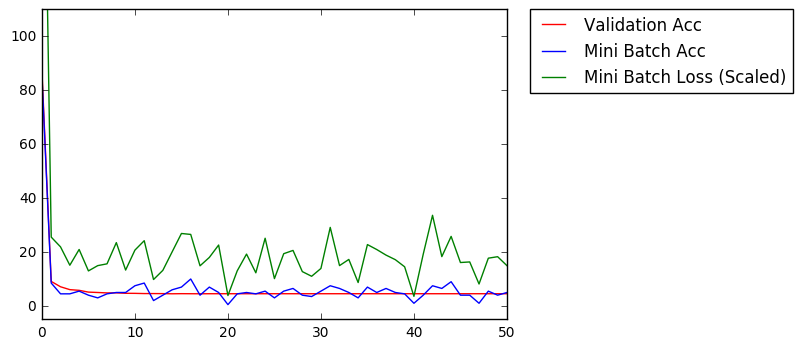

AttributeError: 'numpy.ndarray' object has no attribute 'eval'

In [42]:
log_data = {
    "mini_batch_loss" : [],
    "mini_batch_acc" : [],
    "validation_acc" : [],
    "stepsize" : param['num_log_steps']
}

delete_folder_content(param["log_folder"])

start_time = time.time()
with tf.Session(graph=graph) as session:
    
  session.run(tf.initialize_all_variables())

  summary_writer = tf.train.SummaryWriter(param["log_folder"], session.graph)
    
  print('Initialized')
  for step in range(param['num_steps']):
        
    offset = (step * param['batch_size']) % (train_labels.shape[0] - param['batch_size'])
    
    batch_data = train_data[offset:(offset + param['batch_size']), :, :, :]
    
    batch_labels = train_labels[offset:(offset + param['batch_size']), :]
    
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if (step % param["num_log_steps"] == 0):
      clear_output()
      print("Offset: {}".format(offset))
      print("Progress: {:5.2f}%".format( step*100 / param['num_steps']) )
      print("Elapsed Time: {:4.2f} min".format( (time.time() - start_time) / 60 ))
      print("Minibatch loss at step %d: %f" % (step, l))
      log_data["mini_batch_loss"].append(l * 100)
        
      mini_batch_acc = accuracy(predictions, batch_labels)
      print("Minibatch accuracy: %.1f%%" % mini_batch_acc)
      log_data["mini_batch_acc"].append(100.0 - mini_batch_acc)
    
      val_acc = accuracy( valid_prediction.eval(), validation_labels )
      print("Validation accuracy: %.1f%%" % val_acc )
      log_data["validation_acc"].append(100.0 - val_acc)
      plot_log_data(log_data)
  
  test_acc = accuracy( test_labels.eval(), test_labels )
  print("Test accuracy: %.1f%%" % val_acc )
  print(param)